---

## Context  
Strokes account for 10% of global deaths annually. This project aims to **identify high-risk individuals early** using machine learning, enabling preventative healthcare interventions. 

## Objective  
Build a **binary classification model** to predict stroke risk using demographic and clinical features:  
- **Demographics:** Age, gender, marital status, work type.  
- **Health Metrics:** Hypertension, heart disease, BMI, glucose levels.  
- **Lifestyle:** Smoking status.  

## Dataset  
**Source:** [Kaggle Stroke Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)  
- **Features:**  
  - `age`, `hypertension`, `avg_glucose_level`, `bmi`, etc.  
- **Target:** `stroke` (1 = stroke, 0 = no stroke).  
- **Challenge:** Severe class imbalance (~5% stroke cases).  

## Approach  
1. **EDA:** Analyze distributions, missing values (`bmi` had 3.9% missing).  
2. **Preprocessing:**  
   - Impute missing `bmi` values with median.  
   - Scale numerical features (age, glucose, BMI).  
   - Encode categorical variables (gender, smoking status).  
3. **Modeling:**  
   - Logistic Regression (baseline).  
   - **Class imbalance mitigation:** SMOTE  (synthetic oversampling of minority class).
4. **Evaluation:** Focus on **Recall** (minimize false negatives) and **F1-Score**.  

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import seaborn as sns
from google.colab import files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import CategoricalDtype

In [3]:
!pip install kaggle

In [10]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

import zipfile
with zipfile.ZipFile('stroke-prediction-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('stroke-prediction-dataset')

import pandas as pd
data = pd.read_csv('stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

print("First 5 records:")
print(data.head())

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
stroke-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
First 5 records:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban         

In [11]:
data.columns.unique()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [12]:
data.dtypes

,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


In [13]:
print(data['gender'].unique())
print(data['ever_married'].unique())
print(data['work_type'].unique())
print(data['Residence_type'].unique())
print(data['smoking_status'].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [18]:
work_type = CategoricalDtype(categories = ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], ordered = False)
data['work_type'] = data['work_type'].astype(work_type)

gender = CategoricalDtype(categories = ['Male', 'Female', 'Other'], ordered = False)
data['gender'] = data['gender'].astype(gender)

married = CategoricalDtype(categories = ['Yes', 'No'], ordered = False)
data['ever_married'] = data['ever_married'].astype(married)

residence = CategoricalDtype(categories = ['Urban', 'Rural'], ordered = False)
data['Residence_type'] = data['Residence_type'].astype(residence)

smoking = CategoricalDtype(categories = ['formerly smoked', 'never smoked', 'smokes', 'Unknown'], ordered = False)
data['smoking_status'] = data['smoking_status'].astype(smoking)

In [19]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [20]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['hypertension'].plot(kind='hist', bins=20, title='hypertension')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['heart_disease'].plot(kind='hist', bins=20, title='heart_disease')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='id', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='age', y='hypertension', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='hypertension', y='heart_disease', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='heart_disease', y='avg_glucose_level', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['hypertension'].plot(kind='line', figsize=(8, 4), title='hypertension')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['heart_disease'].plot(kind='line', figsize=(8, 4), title='heart_disease')
plt.gca().spines[['top', 'right']].set_visible(False)

In [24]:
data = data.dropna()

In [25]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,20995.098457,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,77.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,18605.000000,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,37608.000000,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,55220.000000,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [26]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
preprocessor = ColumnTransformer(transformers = [('gender', encoder, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])])
data_ordinal = preprocessor.fit_transform(data)

data[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = data_ordinal
data

<ipython-input-27-372b3cd50fac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = data_ordinal


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,1.0,2.0,1.0,228.69,36.6,1.0,1
2,31112,1.0,80.0,0,1,1.0,2.0,0.0,105.92,32.5,2.0,1
3,60182,0.0,49.0,0,0,1.0,2.0,1.0,171.23,34.4,3.0,1
4,1665,0.0,79.0,1,0,1.0,3.0,0.0,174.12,24.0,2.0,1
5,56669,1.0,81.0,0,0,1.0,2.0,1.0,186.21,29.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,0.0,13.0,0,0,0.0,4.0,0.0,103.08,18.6,0.0,0
5106,44873,0.0,81.0,0,0,1.0,3.0,1.0,125.20,40.0,2.0,0
5107,19723,0.0,35.0,0,0,1.0,3.0,0.0,82.99,30.6,2.0,0
5108,37544,1.0,51.0,0,0,1.0,2.0,0.0,166.29,25.6,1.0,0


In [28]:
data.shape

(4909, 12)

<Axes: >

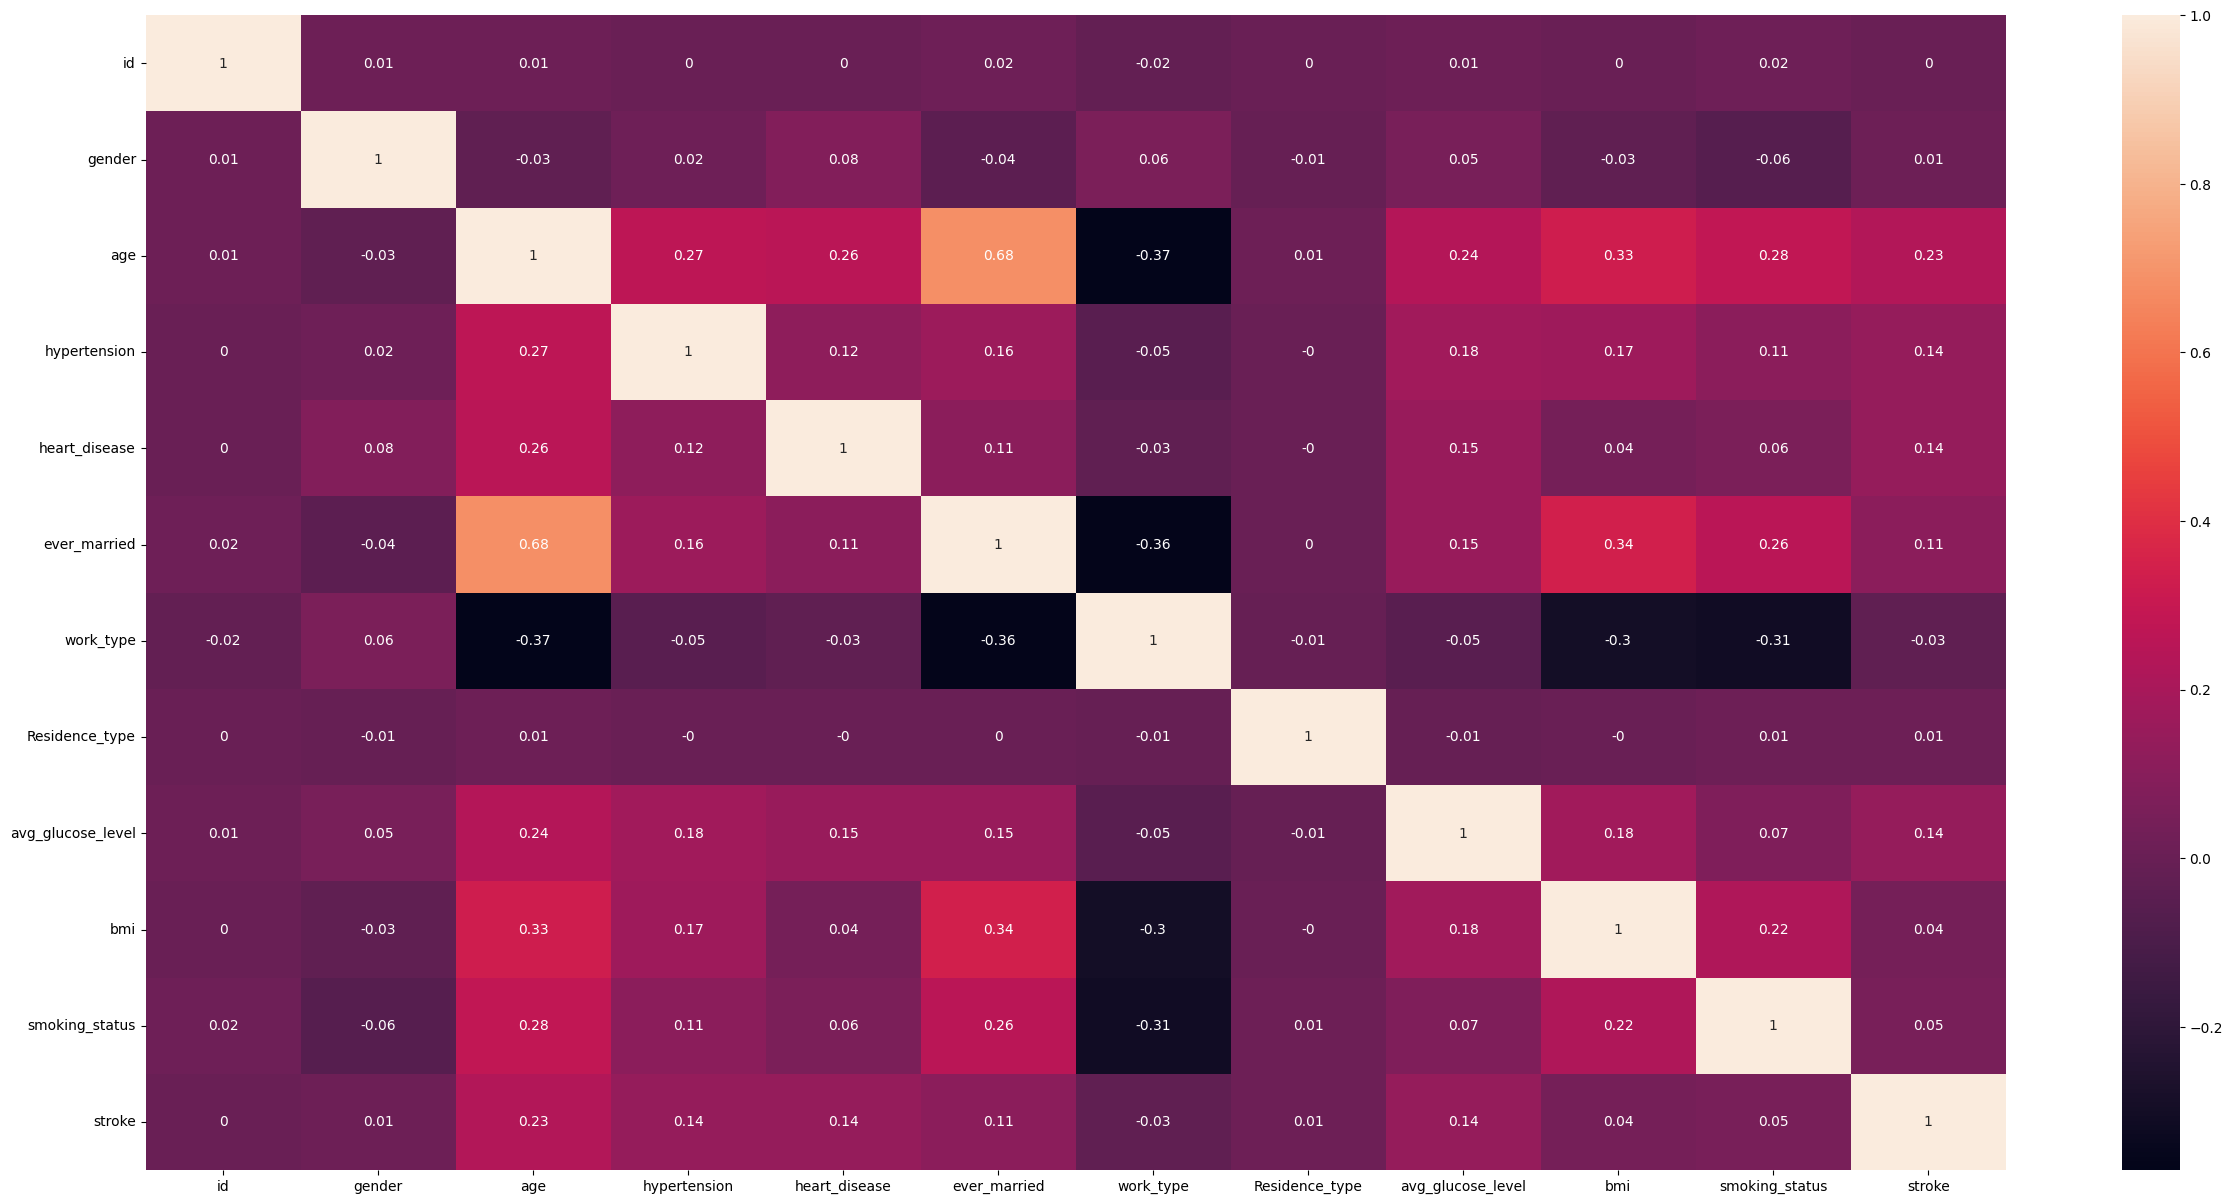

In [31]:
fig, ax = plt.subplots(figsize = (30, 15))
corr = data.corr()
sns.heatmap(corr.round(2), annot = True)

In [37]:
X = data.drop(labels = ['stroke', 'id'], axis = 1)
print(X.shape)

(4909, 10)


In [39]:
y = data['stroke']
print(y.shape)

(4909,)


In [40]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'saga', penalty = 'l1')
lr.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

In [46]:
y_pred_lr = lr.predict(X_test)
y_pred_lr_prob = lr.predict_proba(X_test)

In [47]:
acc_lr_test = accuracy_score(y_test, y_pred_lr)
roc_lr_test = roc_auc_score(y_test, y_pred_lr_prob[:, 1])
prec_lr_test = precision_score(y_test, y_pred_lr)
recall_lr_test = recall_score(y_test, y_pred_lr)

In [48]:
acc_lr_test

0.945010183299389

In [49]:
roc_lr_test

np.float64(0.6534313625931718)

In [50]:
prec_lr_test

0.0

In [51]:
recall_lr_test

0.0

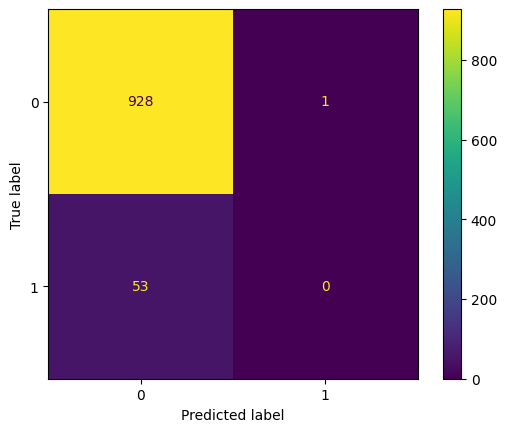

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr.classes_)
disp.plot()

In [54]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [55]:
lr.fit(X_resampled, y_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [56]:
y_pred_lr = lr.predict(X_test)
y_pred_lr_prob = lr.predict_proba(X_test)

In [57]:
acc_lr_test = accuracy_score(y_test, y_pred_lr)
roc_lr_test = roc_auc_score(y_test, y_pred_lr_prob[:, 1])
prec_lr_test = precision_score(y_test, y_pred_lr)
recall_lr_test = recall_score(y_test, y_pred_lr)

In [58]:
acc_lr_test

0.7932790224032586

In [62]:
roc_lr_test

np.float64(0.7927168592724982)

In [59]:
prec_lr_test

0.1527777777777778

In [60]:
recall_lr_test

0.6226415094339622

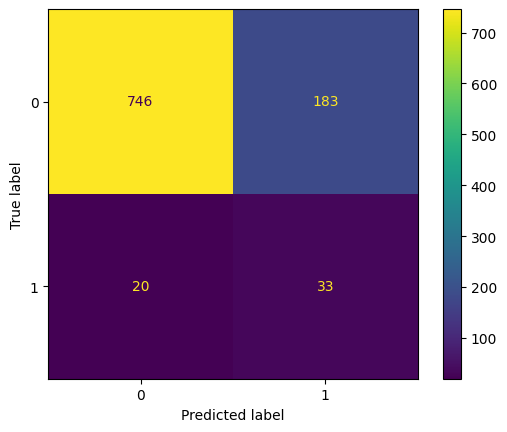

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr.classes_)
disp.plot()